In [25]:
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy import ndimage
from collections import defaultdict
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split, Dataset
import pickle

In [13]:
def extract_digit_regions(image, max_regions=4, threshold=0.5):
    """Extract individual digit regions from the image"""
    # Binarize the image
    binary = (image > threshold).astype(np.uint8)

    # Label connected components
    labeled, num_features = ndimage.label(binary)

    # Get region properties
    regions = []
    for label_idx in range(1, num_features + 1):
        region_mask = labeled == label_idx
        y, x = np.nonzero(region_mask)

        if len(x) < 10:  # Skip very small regions (noise)
            continue

        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        width = x_max - x_min
        height = y_max - y_min
        center_x = (x_max + x_min) // 2

        regions.append({
            'x_min': x_min,
            'x_max': x_max,
            'y_min': y_min,
            'y_max': y_max,
            'width': width,
            'height': height,
            'center_x': center_x,
            'area': len(x)
        })

    # Sort regions by x-coordinate
    regions.sort(key=lambda r: r['center_x'])

    # If we have more regions than expected, merge closest ones
    while len(regions) > max_regions:
        # Find closest pair of regions
        min_dist = float('inf')
        merge_idx = 0

        for i in range(len(regions)-1):
            dist = regions[i+1]['x_min'] - regions[i]['x_max']
            if dist < min_dist:
                min_dist = dist
                merge_idx = i

        # Merge regions
        r1 = regions[merge_idx]
        r2 = regions[merge_idx + 1]
        merged = {
            'x_min': min(r1['x_min'], r2['x_min']),
            'x_max': max(r1['x_max'], r2['x_max']),
            'y_min': min(r1['y_min'], r2['y_min']),
            'y_max': max(r1['y_max'], r2['y_max']),
            'width': max(r1['x_max'], r2['x_max']) - min(r1['x_min'], r2['x_min']),
            'height': max(r1['y_max'], r2['y_max']) - min(r1['y_min'], r2['y_min']),
            'center_x': (r1['center_x'] + r2['center_x']) // 2,
            'area': r1['area'] + r2['area']
        }

        regions[merge_idx:merge_idx + 2] = [merged]

    # Pad with empty regions if we have fewer than expected
    while len(regions) < max_regions:
        regions.append({
            'x_min': 0,
            'x_max': 0,
            'y_min': 0,
            'y_max': 0,
            'width': 0,
            'height': 0,
            'center_x': 0,
            'area': 0
        })

    return regions[:max_regions], binary

def extract_digit_image(image, region, padding=2):
    """Extract a single digit from the image based on region coordinates"""
    h, w = image.shape
    x_min = max(0, region['x_min'] - padding)
    x_max = min(w, region['x_max'] + padding)
    y_min = max(0, region['y_min'] - padding)
    y_max = min(h, region['y_max'] + padding)

    digit = image[y_min:y_max, x_min:x_max]

    # Resize to fixed size (28x28)
    digit = ndimage.zoom(digit, (28/digit.shape[0], 28/digit.shape[1]))

    return digit

In [14]:
class DigitSumDataset(Dataset):
    """Dataset class for digit sum data with individual digit regions"""
    def __init__(self, images, labels):
        self.original_images = torch.FloatTensor(images).reshape(-1, 1, 40, 168)
        self.labels = torch.LongTensor(labels)

        # Process images to get digit regions
        self.digit_regions = []
        self.individual_digits = []

        print("Processing images to extract digits...")
        for img in tqdm(self.original_images[:, 0]):
            regions, _ = extract_digit_regions(img.numpy())
            self.digit_regions.append(regions)

            # Extract individual digits
            digits = []
            for region in regions:
                if region['area'] > 0:
                    digit = extract_digit_image(img.numpy(), region)
                    digits.append(digit)
                else:
                    digits.append(np.zeros((28, 28)))

            self.individual_digits.append(digits)

        # Convert to tensors
        self.individual_digits = torch.FloatTensor(self.individual_digits)
        # Normalize and repeat to 3 channels for ResNet
        self.individual_digits = self.individual_digits.unsqueeze(2).repeat(1, 1, 3, 1, 1)
        self.individual_digits = (self.individual_digits - self.individual_digits.mean()) / self.individual_digits.std()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'digits': self.individual_digits[idx],
            'label': self.labels[idx],
            'regions': self.digit_regions[idx]
        }

class DigitRecognitionModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.digit_cnn = resnet18(weights='DEFAULT')

        # Modify first conv layer to accept single channel
        self.digit_cnn.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify final layer
        in_features = self.digit_cnn.fc.in_features
        self.digit_cnn.fc = nn.Linear(in_features, num_classes)

        # Sum prediction layer
        self.sum_predictor = nn.Sequential(
            nn.Linear(40, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 37)  # 0 to 36 inclusive
        )

    def forward(self, x):
        # x shape: (batch_size, num_digits, channels, height, width)
        batch_size, num_digits = x.shape[:2]

        # Process each digit
        digit_features = []
        for i in range(num_digits):
            digit_out = self.digit_cnn(x[:, i])  # Shape: (batch_size, num_classes)
            digit_features.append(digit_out)

        # Concatenate digit predictions
        digit_preds = torch.stack(digit_features, dim=1)  # Shape: (batch_size, num_digits, num_classes)

        # Predict sum
        sum_pred = self.sum_predictor(digit_preds.view(batch_size, -1))

        return sum_pred

In [15]:
def train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=100):
    """Train the model with progress bars and GPU support"""
    history = defaultdict(list)
    best_val_acc = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch in train_bar:
            digits = batch['digits'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(digits)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            train_bar.set_postfix({
                'loss': f'{train_loss/train_total:.3f}',
                'acc': f'{100.*train_correct/train_total:.2f}%'
            })

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for batch in val_bar:
                digits = batch['digits'].to(device)
                labels = batch['label'].to(device)

                outputs = model(digits)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                val_bar.set_postfix({
                    'loss': f'{val_loss/val_total:.3f}',
                    'acc': f'{100.*val_correct/val_total:.2f}%'
                })

        # Save metrics
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total

        history['train_loss'].append(train_loss / train_total)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss / val_total)
        history['val_acc'].append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_digit_recognition_model.pt')
            print(f'New best model saved with validation accuracy: {val_acc:.2f}%')

    return history

Using device: cuda
Processing images to extract digits...


Epoch 1/100 [Val]: 100%|██████████| 141/141 [00:03<00:00, 45.72it/s, loss=0.077, acc=15.00%]


New best model saved with validation accuracy: 15.00%


Epoch 2/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 48.98it/s, loss=0.065, acc=29.58%]


New best model saved with validation accuracy: 29.58%


Epoch 3/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 48.93it/s, loss=0.057, acc=33.29%]


New best model saved with validation accuracy: 33.29%


Epoch 4/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 48.78it/s, loss=0.051, acc=39.36%]


New best model saved with validation accuracy: 39.36%


Epoch 5/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 49.36it/s, loss=0.048, acc=47.22%]


New best model saved with validation accuracy: 47.22%


Epoch 7/100 [Val]: 100%|██████████| 141/141 [00:03<00:00, 46.96it/s, loss=0.044, acc=56.64%]


New best model saved with validation accuracy: 56.64%


Epoch 9/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 47.23it/s, loss=0.035, acc=65.56%]


New best model saved with validation accuracy: 65.56%


Epoch 10/100 [Val]: 100%|██████████| 141/141 [00:03<00:00, 46.38it/s, loss=0.037, acc=69.11%]


New best model saved with validation accuracy: 69.11%


Epoch 12/100 [Val]: 100%|██████████| 141/141 [00:03<00:00, 45.83it/s, loss=0.032, acc=69.93%]


New best model saved with validation accuracy: 69.93%


Epoch 13/100 [Val]: 100%|██████████| 141/141 [00:03<00:00, 46.03it/s, loss=0.030, acc=72.09%]


New best model saved with validation accuracy: 72.09%


Epoch 14/100 [Val]: 100%|██████████| 141/141 [00:03<00:00, 46.76it/s, loss=0.027, acc=78.40%]


New best model saved with validation accuracy: 78.40%


Epoch 16/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 47.17it/s, loss=0.026, acc=79.80%]


New best model saved with validation accuracy: 79.80%


Epoch 19/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 50.93it/s, loss=0.025, acc=82.82%]


New best model saved with validation accuracy: 82.82%


Epoch 26/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 53.63it/s, loss=0.026, acc=85.24%]


New best model saved with validation accuracy: 85.24%


Epoch 28/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 57.21it/s, loss=0.023, acc=85.44%]


New best model saved with validation accuracy: 85.44%


Epoch 32/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 54.27it/s, loss=0.027, acc=85.49%]


New best model saved with validation accuracy: 85.49%


Epoch 34/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 55.72it/s, loss=0.024, acc=87.29%]


New best model saved with validation accuracy: 87.29%


Epoch 37/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 58.04it/s, loss=0.023, acc=87.67%]


New best model saved with validation accuracy: 87.67%


Epoch 43/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 59.57it/s, loss=0.026, acc=87.82%]


New best model saved with validation accuracy: 87.82%


Epoch 49/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 58.14it/s, loss=0.027, acc=88.18%]


New best model saved with validation accuracy: 88.18%


Epoch 50/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 57.23it/s, loss=0.028, acc=89.24%]


New best model saved with validation accuracy: 89.24%


Epoch 54/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 58.20it/s, loss=0.030, acc=90.24%]


New best model saved with validation accuracy: 90.24%


Epoch 66/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 50.36it/s, loss=0.026, acc=90.29%]


New best model saved with validation accuracy: 90.29%


Epoch 68/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 49.89it/s, loss=0.031, acc=90.51%]


New best model saved with validation accuracy: 90.51%


Epoch 78/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 49.70it/s, loss=0.037, acc=90.84%]


New best model saved with validation accuracy: 90.84%


Epoch 80/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 52.26it/s, loss=0.035, acc=91.40%]


New best model saved with validation accuracy: 91.40%


Epoch 82/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 54.41it/s, loss=0.038, acc=91.93%]


New best model saved with validation accuracy: 91.93%


Epoch 92/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 56.06it/s, loss=0.039, acc=92.22%]


New best model saved with validation accuracy: 92.22%


Epoch 100/100 [Val]: 100%|██████████| 141/141 [00:02<00:00, 56.48it/s, loss=0.038, acc=91.69%]


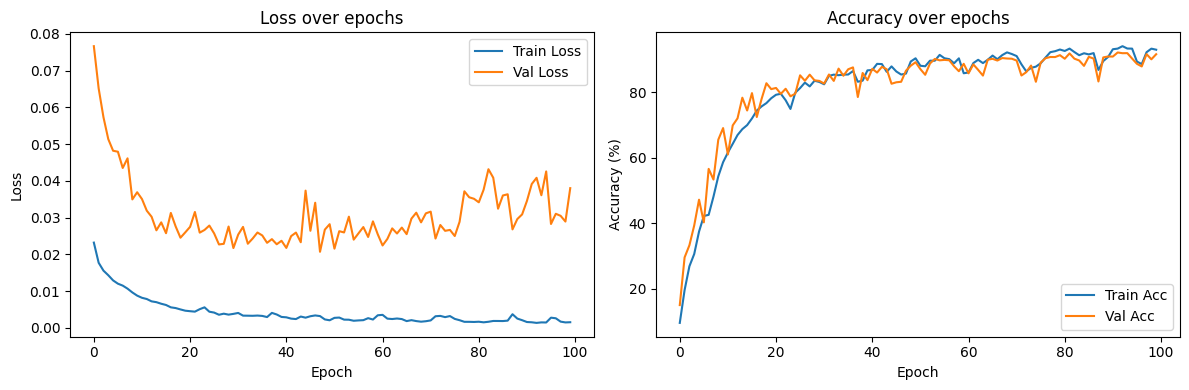

In [7]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load and preprocess data
data_path = './'
train_data = np.concatenate([
    np.load(data_path + f'data{i}.npy') for i in range(3)
])
lab_data = np.concatenate([
    np.load(data_path + f'lab{i}.npy') for i in range(3)
])

# Create dataset
dataset = DigitSumDataset(train_data, lab_data)

# Split dataset
total_size = len(dataset)
train_size = int(0.75 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
model = DigitRecognitionModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Train model
history = train_model(
    train_loader,
    val_loader,
    model,
    criterion,
    optimizer,
    device,
    num_epochs=100
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')


In [26]:
with open('testset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)
with open('valset.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)